# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
sorted_sum_user_interactions = df.groupby('email').count()['title'].sort_values()

sorted_sum_user_interactions[-1]

364

In [4]:
np.median(sorted_sum_user_interactions)

3.0

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(sorted_sum_user_interactions) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = sorted_sum_user_interactions[-1] # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content.drop_duplicates(inplace=True)

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
df.groupby('email').count()['title'].sort_values()

email
6755c5d49a97e785583f65a92f72bc09459905a9      1
3fbe4978a20ee5ddc07648f2762b808ea18cedd1      1
9c4b5dda1282c94128a7dc778951a313cce8055b      1
3fac88958dc7903b380743597f44a79cf76ea128      1
efdb4c363358224cd99d45053e2dbddf659e25ce      1
3faaf951e4fa83cd67032688320d03d832ae708c      1
efded4d12cb4d1f53515e503d4ad3c4ca850a4da      1
3f7be78857cda042074028beed41d088e5dd6a99      1
9cadbc14289d0db3937f00f4f2aab8d49b49680a      1
9cb9845ca344b23b49ad94f4fddbcf95fedc0617      1
dc323e9b8ca2a9bf6397e43063fc093ae90788ea      1
9c2394077e008013b92ec391eaf908d5ef3dd611      1
efe31a945040de5c0b5857b0072dc9254e96b37d      1
9cc6d232298678b4e24cf97ca0c74675fc2f132e      1
9cdb6449c080df01e366ce9c66f07a549be838d9      1
9ce1e204a22ba4cd4a0a53da42238ae830b5879d      1
9ce6218339bd9186a3d0fe7da3494bc5af43dcba      1
9cfa28d68d71ba3fb1bf4745319be2258b87eb92      1
9cfcf871ffb197ba5ad6bc6408ab5dc66d5b796d      1
9d0375f208a9f91db408b5cf8da78e976fed3a55      1
9d3363969ba2a7f1d012d5c55af76652fc

In [9]:
len(df)

45993

In [10]:
df.groupby('article_id').count()['title'].sort_values()

article_id
1092.0      1
984.0       1
417.0       1
1237.0      1
1233.0      1
1202.0      1
1200.0      1
1266.0      1
1072.0      1
724.0       1
1113.0      1
1344.0      1
974.0       1
662.0       1
653.0       1
1119.0      1
675.0       1
1127.0      1
1244.0      2
1130.0      2
364.0       2
1251.0      2
1235.0      2
1135.0      2
1137.0      2
1230.0      2
1067.0      2
1227.0      2
1226.0      2
1210.0      2
         ... 
1052.0    330
1430.0    336
1432.0    340
1276.0    347
151.0     352
1172.0    363
1165.0    372
1336.0    379
1338.0    382
1305.0    413
1368.0    418
1354.0    426
1160.0    433
1185.0    442
1393.0    455
1351.0    457
43.0      460
1398.0    465
1271.0    473
1436.0    481
1304.0    483
1162.0    512
1170.0    565
1293.0    572
1314.0    614
1364.0    627
1427.0    643
1431.0    671
1330.0    927
1429.0    937
Name: title, Length: 714, dtype: int64

In [11]:
len(df_content)

1051

In [12]:
unique_articles = len(df.groupby('article_id').count()['title'].sort_values()) # The number of unique articles that have at least one interaction
total_articles = len(df_content) # The number of unique articles on the IBM platform
unique_users = len(df.groupby('email').count()['title'].sort_values()) # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df.groupby('article_id').count()['title'].sort_values()

article_id
1092.0      1
984.0       1
417.0       1
1237.0      1
1233.0      1
1202.0      1
1200.0      1
1266.0      1
1072.0      1
724.0       1
1113.0      1
1344.0      1
974.0       1
662.0       1
653.0       1
1119.0      1
675.0       1
1127.0      1
1244.0      2
1130.0      2
364.0       2
1251.0      2
1235.0      2
1135.0      2
1137.0      2
1230.0      2
1067.0      2
1227.0      2
1226.0      2
1210.0      2
         ... 
1052.0    330
1430.0    336
1432.0    340
1276.0    347
151.0     352
1172.0    363
1165.0    372
1336.0    379
1338.0    382
1305.0    413
1368.0    418
1354.0    426
1160.0    433
1185.0    442
1393.0    455
1351.0    457
43.0      460
1398.0    465
1271.0    473
1436.0    481
1304.0    483
1162.0    512
1170.0    565
1293.0    572
1314.0    614
1364.0    627
1427.0    643
1431.0    671
1330.0    927
1429.0    937
Name: title, Length: 714, dtype: int64

In [14]:
most_viewed_article_id = df.groupby('article_id').count()['title'].sort_values().index[-1] # The most viewed article in the dataset as a string with one value following the decimal 
max_views = list(df.groupby('article_id').count()['title'].sort_values())[-1] # The most viewed article in the dataset was viewed how many times?

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The article_id of the most viewed article is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ids = results = list(map(float, get_top_article_ids(n, df)))
    articles = pd.concat([df[df['article_id'] == id] for id in ids])
    top_articles = set(articles['title'])
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(np.array(df.groupby('article_id').count()['user_id'].sort_values().index[-n:], dtype=str))
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

{'predicting churn with the spss random tree algorithm', 'use deep learning for image classification', 'healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'gosales transactions for logistic regression model', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization'}
['1304.0', '1162.0', '1170.0', '1293.0', '1314.0', '1364.0', '1427.0', '1431.0', '1330.0', '1429.0']


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id']).any().unstack()
    user_item.replace({True: 1}, inplace=True)
    user_item.fillna(0, inplace=True)
    user_item = user_item.astype('int')
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_id = int(user_id)
    similarities = []
    for index, row in user_item.iterrows():
        similarities.append(np.sum(np.dot(list(user_item.loc[user_id, ]), list(row))))
    user_item_sim = user_item.copy()
    user_item_sim['similarity'] = similarities

    # sort by similarity
    df_sorted = user_item_sim.sort_values('similarity', ascending=False)

    # create list of just the ids
    most_similar_users = list(df_sorted.index)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
                   

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
    columns = np.array(user_item.title.columns)
    filter = np.array(list(user_item.loc[3933, ]), dtype=bool)
    article_ids = columns[filter]
    article_names = df[df.article_id.isin(article_ids)].title
    article_names = set(article_names)
    article_names

{'access db2 warehouse on cloud and db2 with python',
 'analyze db2 warehouse on cloud data in rstudio in dsx',
 'apache spark lab, part 1: basic concepts',
 'categorize urban density',
 'classify tumors with machine learning',
 'country statistics: life expectancy at birth',
 'deep learning with tensorflow course by big data university',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'introducing ibm watson studio ',
 'introduction to market basket analysis in\xa0python',
 'new shiny cheat sheet and video tutorial',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning',
 'python for loops explained (python for data science basics #5)',
 'python if statements explained (python for data science basics #4)',
 'rapidly build machine learning flows with dsx',
 'sector correl

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df.article_id.isin(article_ids)].title
    article_names = set(article_names)
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    columns = np.array(user_item.title.columns)
    filter = np.array(list(user_item.loc[user_id, ]), dtype=bool)
    article_ids = np.array(columns[filter], dtype=str)
    article_names = get_article_names(article_ids)
    return [article_ids, article_names] # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recs = set()
    recs_seen = set(get_user_articles(user_id)[0])
    for similar_user in similar_users:
        set_articles = set(get_user_articles(similar_user)[0])
        recs.update(set_articles - recs_seen)
        recs_seen = recs_seen.union(recs)
        if len(recs) >= m:
            return list(recs)[:m]

    # if the recs list is smaller than m, returns the whole list
    return list(recs)

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

{'1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'a dynamic duo – inside machine learning – medium',
 'analyze open data sets with spark & pixiedust',
 'apache spark lab, part 3: machine learning',
 'deep forest: towards an alternative to deep neural networks',
 'from spark ml model to online scoring with scala',
 'how smart catalogs can turn the big data flood into an ocean of opportunity',
 'modeling energy usage in new york city',
 'using github for project control in dsx',
 'using machine learning to predict parking difficulty'}

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame()

    neighbor_id_list = []
    similarities = []
    interactions = []
    for neighbor_id, row in user_item.iterrows():
        if neighbor_id == user_id:
            continue
        neighbor_id_list.append(neighbor_id)
        similarities.append(np.sum(np.dot(list(user_item.loc[user_id, ]), list(row))))
        interactions.append(df.loc[df.user_id == neighbor_id].count()[0])
    
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id_list, 'similarity': similarities, 'interactions': interactions})
    neighbors_df.sort_values(['similarity', 'interactions'], ascending=[False, False], inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    similar_users = get_top_sorted_users(user_id)
    recs = set()
    recs_seen = set(get_user_articles(user_id)[0])
    for neighbor_id, row in similar_users.iterrows():
        set_articles = set(get_user_articles(neighbor_id)[0])
        recs.update(set_articles - recs_seen)
        recs_seen = recs_seen.union(recs)
        if len(recs) >= m:
            break
    
    sub_set = df[df['article_id'].isin(recs)]
    recs = get_top_article_ids(m, sub_set)
    rec_names = get_article_names(recs)
    return recs, rec_names

In [29]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1430.0', '1276.0', '1165.0', '1338.0', '1354.0', '1185.0', '1398.0', '1162.0', '1364.0', '1429.0']

The top 10 recommendations for user 20 are the following article names:
{'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'analyze precipitation data', 'movie recommender system with spark machine learning', 'total population by country', 'deploy your python model as a restful api', 'using pixiedust for fast, flexible, and easier data analysis and experimentation', 'analyze energy consumption in buildings', 'ml optimization using cognitive assistant', 'classify tumors with machine learning'}


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [30]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id

In [31]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If I had to make recommendations for a new user, I would use the first approach, which recommends the most popular articles using the function `get_top_article_ids`.

This is necessary because it's not possible to verify which users are similar to the new user, because the new user doesn't have any interaction with any article, so the Collaborative Filtering is not possible.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [32]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [33]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix.astype(float).values,full_matrices=False)# use the built in to get the three matrices

**Provide your response here.**

During the lesson, the Funk-SVD was used because the dataset contained a lot of null values (NaN - Not a Number). In this notebook, the dataset doesn't have any null values, so we can use the SVD from numpy.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [37]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.unique().tolist()
    test_arts = user_item_test.columns.tolist()    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [38]:
len(set(user_item_test.index).intersection(set(user_item_train.index)))

20

In [39]:
len(set(user_item_test.index) - set(user_item_train.index))

662

In [40]:
len(set(user_item_test.columns).intersection(set(user_item_train.columns)))

574

In [41]:
len(set(user_item_test.columns) - set(user_item_train.columns))

0

In [42]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [43]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [44]:
pred_idx = np.intersect1d(user_item_test.index,user_item_train.index)
pred_arts = np.intersect1d(user_item_test.columns,user_item_train.columns)

In [45]:
user_item_test_filtered = user_item_test.loc[pred_idx, pred_arts]

In [46]:
row_idx_mask = user_item_train.index.isin(test_idx)
col_idx_mask = user_item_train.columns.isin(test_arts)

In [47]:
u_test = u_train[row_idx_mask, :]
vt_test = vt_train[:, col_idx_mask]

### Creating a function to predict and compute the acuracy for different number of latent features

In [48]:
def predict(u, s, vt, user_matrix):
    '''
    INPUT:
    u, s and vt - SVD matrices
    user_matrix - (pandas dataframe) a user-item matrix used to evaluate the predictions
                  made by using SVD decomposition with different number of latent features.

    OUTPUT:
    None
    
    The function plots a graph with the Accuracy for each number of Latent features used.
    '''
    latent_features = np.arange(10, 510, 20)
    sum_errs = []

    for lf in latent_features:

        s_pred, u_pred, vt_pred = np.diag(s[:lf]), u[:, :lf], vt[:lf, :]

        user_item_pred = np.round(np.dot(np.dot(u_pred, s_pred), vt_pred))

        diff = np.subtract(user_matrix, user_item_pred)
        err = np.sum(np.sum(np.abs(diff)))
        sum_errs.append(err)

    plt.plot(latent_features, 1 - np.array(sum_errs) / df.shape[0]);
    plt.xlabel('Latent Features');
    plt.ylabel('General Accuracy');
    plt.title('General Accuracy vs. Latent Features');

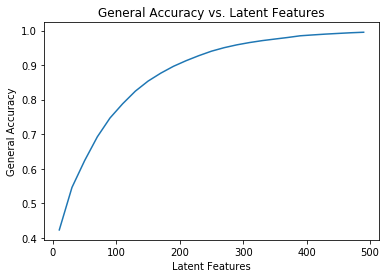

In [49]:
predict(u_train, s_train, vt_train, user_item_train)

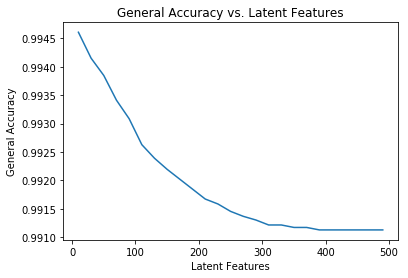

In [50]:
predict(u_test, s_train, vt_test, user_item_test_filtered)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Just by using the simple accuracy, it seems that we have some problems.

We have a problem with overfitting the data when using more latent features. This can lead us to believe that more latent features will give worst results, because the accuracy of the test only gets worse when increasing the latent features.

This can happen because of the dataset: once the matrix used is very sparse.

Another approach would be to use a different score than the simple accuracy, like the F1-Score. This type of score is interesting for unbalanced data, or in our case, when the user-item matrix is very sparse as this one.

A function that performs the same prediction and evaluation of different latent features, but using the F1-Score is provided in the next cells in order to verify if the overfitting is, in fact, happening.

As we can see in the next graphs, the results on the test set show that the best number for latent features are between 50 and 100.

Other approach to this problem would be using A/B tests or a feedback system, where users can tell the system if the recommendation was good or not, and based on this data we can provide better suggestions.

In [51]:
from sklearn.metrics import f1_score
def predict_f1(u, s, vt, user_matrix):
    '''
    INPUT:
    u, s and vt - SVD matrices
    user_matrix - (pandas dataframe) a user-item matrix used to evaluate the predictions
                  made by using SVD decomposition with different number of latent features.

    OUTPUT:
    None
    
    The function plots a graph with the F1-Score for each number of Latent features used.
    '''
    latent_features = np.arange(10, 510, 20)
    f1_list = []

    for lf in latent_features:

        s_pred, u_pred, vt_pred = np.diag(s[:lf]), u[:, :lf], vt[:lf, :]
        user_item_pred = np.around(np.dot(np.dot(u_pred, s_pred), vt_pred))

        f1_list.append(f1_score(user_matrix.astype(bool).values.flatten(),
                                user_item_pred.astype(bool).flatten()))

    plt.plot(latent_features, np.array(f1_list));
    plt.xlabel('Number of Latent Features');
    plt.ylabel('F1');
    plt.title('F1 vs. Number of Latent Features');

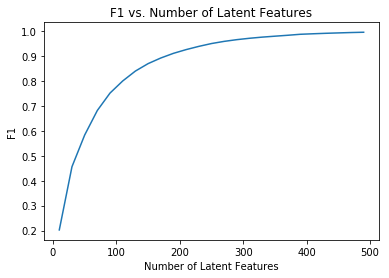

In [52]:
predict_f1(u_train, s_train, vt_train, user_item_train)

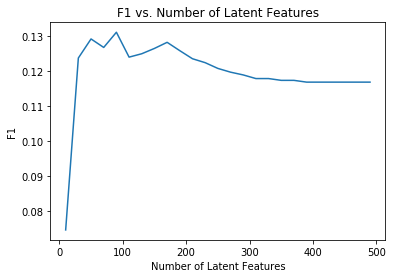

In [53]:
predict_f1(u_test, s_train, vt_test, user_item_test_filtered)

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0